In [1]:
# !pip install transformers
!pip install --no-cache-dir transformers sentencepiece
import json
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel, AutoModelForSeq2SeqLM
import torch
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
from matplotlib.pyplot import figure

import nltk
nltk.download('punkt')

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 24.7 MB/s 
     |████████████████████████████████| 6.6 MB 11.6 MB/s 
     |████████████████████████████████| 596 kB 50.8 MB/s 
     |████████████████████████████████| 77 kB 40.8 MB/s 
     |████████████████████████████████| 880 kB 48.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=52441da26b25d9d2be7fc89afd9224675b5616df365c3cc82c5c3b68f62889c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-vdof8zs_/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')
with open("/content/drive/MyDrive/CMSC848Q/multilingual-qa-bias/mDPR/xor_dev_dpr_retrieval_xlingual_samples.json") as f:
  xlingual_samples = json.load(f)

Mounted at /content/drive


###XLM Roberta Embeddings

In [2]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

###Sentence Embeddings

In [4]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [5]:
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
# model = AutoModel.from_pretrained('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v2')
model = AutoModel.from_pretrained('sentence-transformers/distiluse-base-multilingual-cased-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

print("Sentence embeddings:")
print(sentence_embeddings)

Downloading:   0%|          | 0.00/531 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/610 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/514M [00:00<?, ?B/s]

Sentence embeddings:
tensor([[ 0.0789,  0.0301, -0.1049,  ...,  0.0582,  0.0896, -0.0407],
        [ 0.0042,  0.0390, -0.0065,  ...,  0.0326, -0.0006, -0.0060]])


In [6]:
sentence_embeddings.shape

torch.Size([2, 768])

In [36]:
with open("/content/drive/MyDrive/CMSC848Q/multilingual-qa-bias/question_vectors/f1_vecs") as f:
  f1_dict = json.load(f)

In [37]:
len(f1_dict), len(xlingual_samples)

(146, 146)

In [41]:
f1_dict[0]

{'ar': -1,
 'bn': -1,
 'de': -1,
 'en': 0.6666666666666666,
 'es': 0.6,
 'et': -1,
 'fi': -1,
 'id': 0.33333333333333337,
 'ko': -1,
 'ru': -1,
 'sv': -1,
 'te': 0,
 'tr': 0.5}

In [44]:
# all_sent_sim = []
# all_sent_embed = []
all_cos_sim = []
all_f1_diff = []
for sample, f1_scores in zip(xlingual_samples, f1_dict):
  all_contexts = {}
  all_score = defaultdict(float)
  for datum in sample:
    l = datum['context']['ctx_lang']
    score = float(datum['context']['score'])
    if score < all_score[l]: continue
    all_score[l] = score
    all_contexts[l] = datum['context']['text']

  for i, lang1 in enumerate(f1_scores):
    for j, lang2 in enumerate(f1_scores):
      if i >= j:
        continue
      if f1_scores[lang1] == -1 or f1_scores[lang2] == -1: continue

      encoded_input = tokenizer([all_contexts[lang1], all_contexts[lang2]], 
                                padding=True, truncation=True, return_tensors='pt')
      with torch.no_grad():
        model_output = model(**encoded_input)
      sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
      s1 = sentence_embeddings[0]
      s2 = sentence_embeddings[1]
      cos_sim = 1 - spatial.distance.cosine(s1.tolist(), s2.tolist())
      all_cos_sim.append(cos_sim)
      all_f1_diff.append(abs(f1_scores[lang1] - f1_scores[lang2]))

  # all_contexts = list(all_contexts.values())
  # encoded_input = tokenizer(all_contexts, padding=True, truncation=True, return_tensors='pt')
  # with torch.no_grad():
  #     model_output = model(**encoded_input)

  # sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  # all_sent_embed.extend(sentence_embeddings)

  # sent_sim = []
  # for i, s1 in enumerate(sentence_embeddings):
  #   for j, s2 in enumerate(sentence_embeddings):
  #     if i >= j:
  #       continue
  #     sent_sim.append(1 - spatial.distance.cosine(s1.tolist(), s2.tolist()))
  # sent_sim = np.array(sent_sim)
  # all_sent_sim.append(np.average(sent_sim))

In [10]:
all_lang = set()
for f1 in f1_dict:
  for la in f1:
    all_lang.add(la)

all_lang = list(all_lang)

In [28]:
all_f1_res = []
for f1 in f1_dict:
  all_f1_res.append(np.average([f1[la] for la in all_lang if f1[la] != -1]))

Text(0, 0.5, 'Average pairwise context embedding similarity')

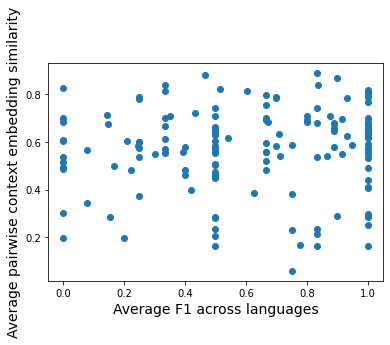

In [33]:
plt.scatter(all_f1_res, all_sent_sim)
plt.xlabel("Average F1 across languages", fontsize=14)
plt.ylabel("Average pairwise context embedding similarity", fontsize=14)

Text(0, 0.5, 'Pairwise F1 difference')

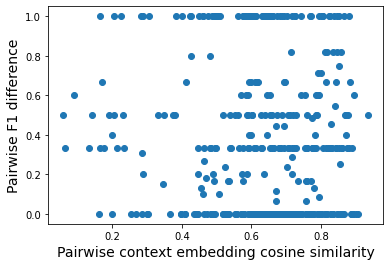

In [46]:
plt.scatter(all_cos_sim, all_f1_diff)
plt.xlabel("Pairwise context embedding cosine similarity", fontsize=14)
plt.ylabel("Pairwise F1 difference", fontsize=14)

2